If additional cations are included, they may be included as (screened) Coulomb interactions with additional LJ/Buckingham potentials.
ref: https://pubs.rsc.org/en/Content/ArticleLanding/2011/CP/c1cp21034c

Solubility of CO2 is approximately 1g/kg H2O at 300 K, so there is approximately 2500 water molecules per molecule of CO2.

In [1]:
%pylab inline

import os, sys
sys.path.append("..")

from lammpsrun import LAMMPS, Prism
from PBSJobSubmissionScript import PBS_Submitter, qstat_monitor
from utility_scripts import *

from ase import Atoms, units
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write
from ase.build import molecule
from ase.spacegroup import crystal
#from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii
#from ase.neighborlist import neighbor_list

cx1_out = r"/rds/general/user/yx6015/home/cx1_out/"
sim_path = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/"
print(cx1_out + '\n' + sim_path)

Populating the interactive namespace from numpy and matplotlib
/rds/general/user/yx6015/home/cx1_out/
/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/


# Creating bulk water region

In [2]:
H2O_bulk = create_water_region([32, 32, 32])
H2O_bulk

Atoms(symbols='H2000O1000', pbc=True, cell=[32.0, 32.0, 32.0])

# Replace with a single atom of CO2

In [3]:
random.seed(1050027)
n_remove = randint(0, H2O_bulk.get_number_of_atoms())

CO2_solvation = replace_molecule(H2O_bulk, n_remove, molecule('CO2'), cut_off = 0.8)
CO2_solvation

Atoms(symbols='CH1998O1001', pbc=True, cell=[32.0, 32.0, 32.0])

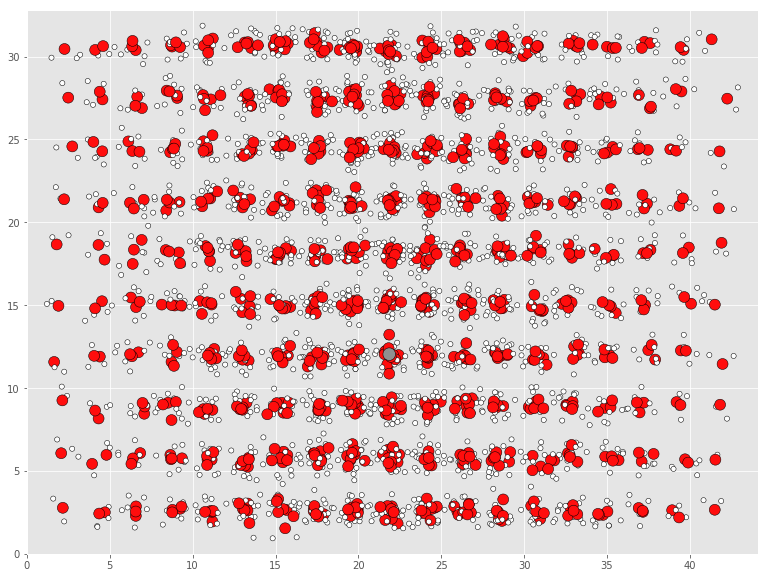

In [8]:
#style.use('dark_background')
style.use('ggplot')
figure(figsize=(18, 10))
plot_atoms(CO2_solvation, radii=0.5, rotation=('90x,45y,0z'))
write("co2_hydration/CO2_solvation.extxyz", CO2_solvation, format = "extxyz")
show()

In [4]:
CO2_solvation_names = ["CO2_solvation_300K"]
CO2_solvation_calc = reaxff_params_generator(CO2_solvation, CO2_solvation_names[0], write=True,
                                             input_fd=sim_path + "co2_hydration/",
                                             run=100000,
                                             timestep=0.25,
                                             fix=["all_nvt all nvt temp 300.0 300.0 100.0",
                                                  "qeq_reaxc all qeq/reax 1 0.0 10.0 1e-6 reax/c",
                                                  "reax_info all reax/c/bonds 10 bonds.tatb"])

In [5]:
CO2_solvation_potential = 'ffield.reax.Fe_O_C_H_combined'
CO2_solvation_input = ["{0}.lammpsin".format(x) for x in CO2_solvation_names]
CO2_solvation_commands = ["mpiexec lmp_intel_cpu_intelmpi -in {0} -screen none\n".format(x) for x in CO2_solvation_input]
CO2_solvation_source_files = ['$HOME/LAMMPS_Simulation/potentials/{0}'.format(CO2_solvation_potential)]
CO2_solvation_source_files.extend(['$PBS_O_WORKDIR/'+x+".lammps*" for x in CO2_solvation_names])

CO2_solvation_PBS = PBS_Submitter(job_names=CO2_solvation_names,
                                  job_commands=CO2_solvation_commands,
                                  modules=["mpi", "lammps/11Aug17", "intel-suite/2017"],
                                  walltime="16:00:00",
                                  proc_nodes=1,
                                  proc_cpus=8,
                                  proc_mpiprocs=8,
                                  memory=4,
                                  source_files=CO2_solvation_source_files)
CO2_solvation_PBS.params

{'source_files': [['$HOME/LAMMPS_Simulation/potentials/ffield.reax.Fe_O_C_H_combined',
   '$PBS_O_WORKDIR/CO2_solvation_300K.lammps*']],
 'job_names': ['CO2_solvation_300K'],
 'job_commands': [['mpiexec lmp_intel_cpu_intelmpi -in CO2_solvation_300K.lammpsin -screen none\n']],
 'modules': [['mpi', 'lammps/11Aug17', 'intel-suite/2017']],
 'walltime': ['16:00:00'],
 'proc_nodes': [1],
 'proc_cpus': [8],
 'proc_mpiprocs': [8],
 'memory': [4]}

In [6]:
curr_dir = os.getcwd()
os.chdir(sim_path + "co2_hydration")

CO2_solvation_out, CO2_solvation_err = CO2_solvation_PBS.run()

os.chdir(curr_dir)

In [ ]:
qstat_monitor()

           JobID        Job Name            User         Runtime          Status           Queue
     2150320.cx1 CO2_solvation_3          yx6015        02:12:29               R v1_throughput24
     2150321.cx1       CO2_10_aq          yx6015        02:12:24               R v1_throughput24
Running...


In [ ]:
# Converting lammpstrj to ase traj
CO2_solvation_calc.trajectory_out = Trajectory(sim_path + "co2_hydration/CO2_solvation_300K.traj", 'w')
CO2_solvation_calc.read_lammps_trj(lammps_trj = cx1_out + CO2_solvation_out[0] + r"/CO2_solvation_300K.lammpstrj")
CO2_solvation_calc.trajectory_out.close()

# Try again with 10 CO2 molecules

H2CO3 lasts ~100ns, about 1% of CO2 gets hydrated.

In [7]:
random.seed(1050027)
ns_remove = random.choice(int(H2O_bulk.get_number_of_atoms()/3), size=20, replace=False)*3

CO2_10_aq = H2O_bulk.copy()
for n in ns_remove:
    CO2_10_aq = replace_molecule(CO2_10_aq, n, molecule('CO2'), cut_off=0.6)
CO2_10_aq

Atoms(symbols='C20H1960O1020', pbc=True, cell=[32.0, 32.0, 32.0])

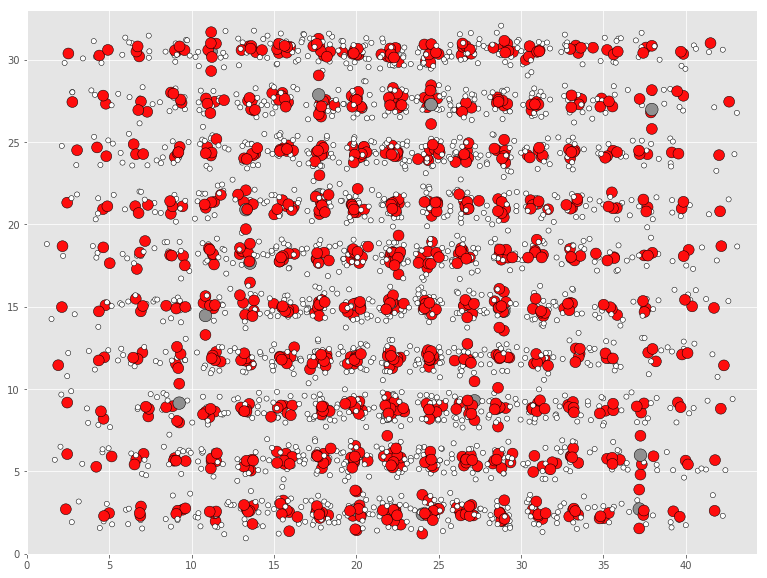

In [8]:
#style.use('dark_background')
style.use('ggplot')
figure(figsize=(18, 10))
plot_atoms(CO2_10_aq, radii=0.5, rotation=('90x,45y,0z'))
write("co2_hydration/CO2_20_aq.extxyz", CO2_10_aq, format = "extxyz")
show()

In [16]:
CO2_10_aq_names = ['CO2_20_aq']
CO2_10_aq_calc = reaxff_params_generator(CO2_10_aq, CO2_10_aq_names[0], write=True,
                                         input_fd=sim_path + "co2_hydration/",
                                         run=10000,
                                         minimize=["1e-25 1e-25 100 100000"],
                                         timestep=0.1,
                                         fix=["all_nvpt all npt/intel temp 300.0 300.0 100.0 iso 1.0 1.0 1000.0",
                                              "qeq_reaxc all qeq/reax/omp 1 0.0 10.0 1e-6 reax/c",
                                              "reax_info all reax/c/bonds 10 bonds.tatb"])

In [17]:
CO2_10_aq_potential = 'ffield.reax.Fe_O_C_H_combined'
CO2_10_aq_input = ["{0}.lammpsin".format(x) for x in CO2_10_aq_names]
CO2_10_aq_commands = ["mpiexec lmp_intel_cpu_intelmpi -sf omp -pk omp 1 -in {0} -screen none\n".format(x) for x in CO2_10_aq_input]
CO2_10_aq_source_files = ['$HOME/LAMMPS_Simulation/potentials/{0}'.format(CO2_10_aq_potential)]
CO2_10_aq_source_files.extend(['$PBS_O_WORKDIR/'+x+".lammps*" for x in CO2_10_aq_names])

CO2_10_aq_PBS = PBS_Submitter(job_names=CO2_10_aq_names,
                                  job_commands=CO2_10_aq_commands,
                                  modules=["mpi", "lammps/11Aug17", "intel-suite/2017"],
                                  walltime="24:00:00",
                                  proc_nodes=1,
                                  proc_cpus=8,
                                  proc_mpiprocs=8,
                                  proc_threads=1,
                                  memory=24,
                                  source_files=CO2_10_aq_source_files)

In [18]:
curr_dir = os.getcwd()
os.chdir(sim_path + "co2_hydration")

CO2_10_aq_out, CO2_10_aq_err = CO2_10_aq_PBS.run()

os.chdir(curr_dir)